In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from joblib import dump
from joblib import load
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling  import RandomOverSampler

## Data Preparation

In [2]:
%%capture
all_ratings = pd.read_csv('https://raw.githubusercontent.com/baiyuankok/EEG-Analysis/master/STEW%20Original%20Dataset/ratings.txt', header=None)
current_dir = os.listdir('D:\\New folder\\Semester 7\\CAT 400\\STEW Features (Classification-Copy3 (for KNN)-Improved)')
current_dir

In [3]:
eeg_data = []
ratings_list = []
iterator = 1

for current_file in current_dir:
    if current_file[-3:] == 'csv':
        subject = int(current_file[0:2])
        rating = all_ratings[all_ratings[0] == subject] 
        if len(rating)==0:
            rating_array = np.array([[0,0,0]])
        else:
            rating_array = rating.values
        
        current_file_dataframe = pd.read_csv('D:\\New folder\\Semester 7\\CAT 400\\STEW Features (Classification-Copy3 (for KNN)-Improved)\\' + current_file, header='infer', index_col=0)
        eeg_data_numerical = current_file_dataframe.to_numpy().reshape(1, -1, 70)
        current_file_dataframe['subj'] = subject
        current_file_dataframe['hilo'] = current_file[3:5]
        if current_file[3:5] == 'hi':
            current_file_dataframe['subjective_rating'] = rating_array[0][2]
            ratings_list.append(rating_array[0][2])
        else:
            current_file_dataframe['subjective_rating'] = rating_array[0][1]
            ratings_list.append(rating_array[0][1])
            
        if iterator == 1:
            X = eeg_data_numerical
        else:
            X = np.insert(X, len(X), eeg_data_numerical, axis=0)
        iterator += 1

        y = np.array(ratings_list)

In [4]:
X.shape, y.shape

((90, 149, 70), (90,))

## Adjust classification into 5 levels

In [5]:
# 1 = Very Low (1), 2 to 3 = Low (2), 4 to 5 Balanced (3), 6 to 7 High (4), 8 to 9 Very High (5)
subjective_ratings_grouped = [ 1 if (i == 1) else 2 if (2 <= i <= 3) else 3 if (4 <= i <= 5) else 4 if (6 <= i <= 7) else 5 for i in y ]

In [6]:
y = np.array(subjective_ratings_grouped)

In [7]:
list(y).count(1), list(y).count(2), list(y).count(3), list(y).count(4), list(y).count(5)

(23, 19, 16, 18, 14)

## Split Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify= y, random_state = 4)

In [9]:
list(y_train).count(1), list(y_train).count(2), list(y_train).count(3), list(y_train).count(4), list(y_train).count(5)

(17, 14, 12, 13, 11)

In [10]:
list(y_test).count(1), list(y_test).count(2), list(y_test).count(3), list(y_test).count(4), list(y_test).count(5)

(6, 5, 4, 5, 3)

## Reshape dataset from 3-dimension to 2-dimension

In [11]:
nsamples, nx, ny = X_train.shape
X_train_reshaped = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test_reshaped = X_test.reshape((nsamples,nx*ny))

In [14]:
list(y_train).count(1), list(y_train).count(2), list(y_train).count(3), list(y_train).count(4), list(y_train).count(5)

(17, 14, 12, 13, 11)

In [15]:
X_train_reshaped.shape

(67, 10430)

## RandomSearchCV

In [16]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

def randomSearchForBestParameter(clf, param_grid, title, X_train, y_train):
    # -----------------------------------------------------
#     cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    n_iter_search = 100
    randomSearch = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            scoring= 'accuracy')
    # -----------------------------------------------------
    # Train model
    randomSearch.fit(X_train, y_train)  
    print("The best parameters are %s" % (randomSearch.best_params_)) 
    return randomSearch.best_estimator_

## KNN

The best parameters are {'weights': 'uniform', 'n_neighbors': 15}
Best: 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
              precision    recall  f1-score   support

           1       0.25      0.33      0.29         6
           2       0.00      0.00      0.00         5
           3       0.12      0.25      0.17         4
           4       0.50      0.40      0.44         5
           5       0.00      0.00      0.00         3

    accuracy                           0.22        23
   macro avg       0.17      0.20      0.18        23
weighted avg       0.20      0.22      0.20        23



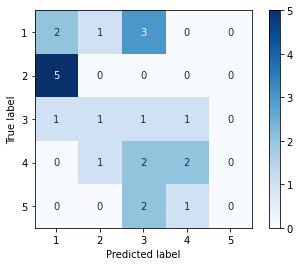

In [18]:
knn_classifier = KNeighborsClassifier()

param_grid = {'n_neighbors': [5, 10, 15, 20],
             'weights': ['uniform', 'distance']}

knn_classifier_best = randomSearchForBestParameter(knn_classifier, param_grid, "K Neighbour", X_train_reshaped, y_train)
print("Best: ")
print(knn_classifier_best.get_params())

knn_classifier_best.fit(X_train_reshaped, y_train)
y_predict = knn_classifier_best.predict(X_test_reshaped)

class_names = list(set(y))
disp = plot_confusion_matrix(knn_classifier_best, X_test_reshaped, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

print(classification_report(y_test, y_predict))

## SVM

### RBF

The best parameters are {'gamma': 0.01, 'class_weight': 'balanced', 'C': 10.0}
Best: 
{'C': 10.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           1       0.28      0.83      0.42         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.50      0.20      0.29         5
           5       0.00      0.00      0.00         3

    accuracy                           0.26        23
   macro avg       0.16      0.21      0.14        23
weighted avg       0.18      0.26      0.17        23



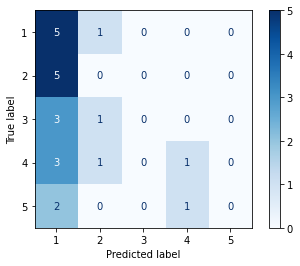

In [21]:
svm_rbf = SVC(kernel="rbf", probability=True)

param_grid = {'gamma': np.logspace(-2, 2, 5),
              'C': np.logspace(-2, 2, 5),
             'class_weight': ['balanced']}

svm_rbf_best = randomSearchForBestParameter(svm_rbf, param_grid, "RBF SVM", X_train_reshaped, y_train)
print("Best: ")
print(svm_rbf_best.get_params())

svm_rbf_best.fit(X_train_reshaped, y_train)
y_predict = svm_rbf_best.predict(X_test_reshaped)

class_names = list(set(y))
disp = plot_confusion_matrix(svm_rbf_best, X_test_reshaped, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

print(classification_report(y_test, y_predict))

## Random Forest

The best parameters are {'random_state': 42, 'n_estimators': 350, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'bootstrap': True}
Best: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 350, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           1       0.38      0.83      0.53         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.75      0.60      0.67         5
           5       0.00      0.00      0.00         3

    accuracy                           0.35        23
   macro avg       0.23      0.29      0.24        23
weighted avg

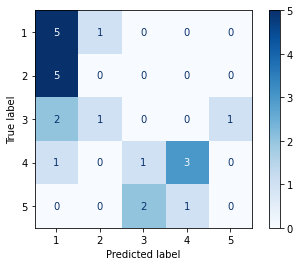

In [17]:
rf = RandomForestClassifier()

param_grid = {'bootstrap': [True],
             'max_features': ['auto'],
             'min_samples_leaf': [4],
             'min_samples_split': [5],
             'n_estimators': range(50, 800, 50),
             'random_state': [42]}

rf_best = randomSearchForBestParameter(rf, param_grid, "Random Forest", X_train_reshaped, y_train)
print("Best: ")
print(rf_best.get_params())
rf_best.fit(X_train_reshaped, y_train)
y_predict = rf_best.predict(X_test_reshaped)

class_names = list(set(y))
disp = plot_confusion_matrix(rf_best, X_test_reshaped, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

print(classification_report(y_test, y_predict))